In [1]:
# Import libraries

import pandas as pd
from collections import Counter
import numpy as np
from numpy import mean
from numpy import std

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from imblearn.over_sampling import SMOTE

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from matplotlib import pyplot

In [2]:
file = 'clean_ml_data_0625.csv'
clean_df = pd.read_csv(file)
clean_df = clean_df.sample(30000)
clean_df.head()

,gender,pneumonia,pregnant,diabetes,copd,asthma,immunosup,hypertension,cardiovascular,obesity,renal_chronic,tobacco,closed_contact,another_complication,death,intubation,ICU,new_age
90796,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,5
114011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
786009,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
209565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
866633,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4


In [3]:
## getting column names
x_columns = ["gender","pneumonia","pregnant","diabetes","copd","asthma","immunosup","hypertension","cardiovascular","obesity","renal_chronic","tobacco","closed_contact","another_complication", "new_age"]
y = clean_df["death"]
X = clean_df[x_columns]

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state =42, stratify=y)

In [5]:
# Creating StandardScaler instance
scaler = StandardScaler()
# Fitting standard scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [6]:
# Resample the training data with SMOTE

X, y = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(X_train_scaled,y_train)
Counter(y)

Counter({0: 20139, 1: 20139})

In [7]:
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[ True  True False  True False False False False False  True  True False
  True False  True]
[1 1 3 1 6 8 7 4 9 1 1 5 1 2 1]


In [8]:
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X, y)
# display the relative importance of each attribute
print(model.feature_importances_)

[0.03265944 0.4540335  0.0009081  0.04036988 0.00780463 0.00444804
 0.00546392 0.05939015 0.0063396  0.01350905 0.01132216 0.00834023
 0.08912458 0.00730958 0.25897713]


In [9]:
# evaluate RFE for classification
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# print(n_scores)

Accuracy: 0.884 (0.005)


>2 0.866 (0.005)
>3 0.877 (0.005)
>4 0.880 (0.005)
>5 0.881 (0.005)
>6 0.884 (0.005)
>7 0.884 (0.005)
>8 0.886 (0.005)
>9 0.886 (0.005)
>10 0.886 (0.006)
>11 0.887 (0.005)
>12 0.887 (0.006)
>13 0.887 (0.005)
>14 0.887 (0.005)


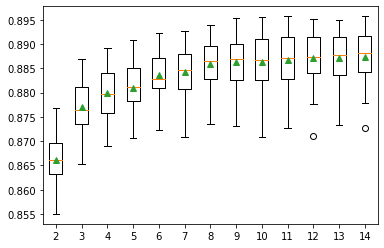

In [10]:
 # get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(2, 15):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, x, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [11]:
# report which features were selected by RFE
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier())
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(len(x_columns)):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
x_columns = ["gender","pneumonia","diabetes","hypertension","obesity","closed_contact", "new_age"]

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected False, Rank: 9.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected False, Rank: 6.000
Column: 5, Selected False, Rank: 8.000
Column: 6, Selected False, Rank: 7.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 5.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 3.000
Column: 11, Selected False, Rank: 2.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected False, Rank: 4.000
Column: 14, Selected True, Rank: 1.000


>lr 0.882 (0.005)
>dt 0.884 (0.005)
>rf 0.884 (0.005)
>gb 0.883 (0.006)
>svm 0.882 (0.005)


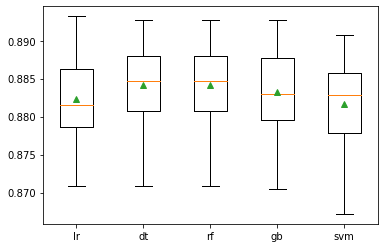

In [13]:
# get a list of models to evaluate
def get_models():
	models = dict()
	# lr
	rfe = RFE(estimator=LogisticRegression(), n_features_to_select=7)
	model = DecisionTreeClassifier()
	models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
	# cart
	rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=7)
	model = DecisionTreeClassifier()
	models['dt'] = Pipeline(steps=[('s',rfe),('m',model)])
	# rf
	rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=7)
	model = DecisionTreeClassifier()
	models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
	# gbm
	rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=7)
	model = DecisionTreeClassifier()
	models['gb'] = Pipeline(steps=[('s',rfe),('m',model)])
    # SVM
	rfe = RFE(estimator=SVC(kernel="linear"), n_features_to_select=7)
	model = DecisionTreeClassifier()
	models['svm'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, x, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()